# Noise reduction for ECG

In [11]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
sns.set_style('darkgrid')

In [4]:
plt.rcParams['figure.figsize'] = [8, 5]  # Bigger images

## Import noisy signal

In [5]:
data, sampling_rate = nk.read_acqknowledge("C:/Users/sangfrois/Desktop/NeuroMod_tests/mockExperiment/biopac_test_2019-07-03_sub3_sangfrois.acq")

In [6]:
sampling_rate

10000.0

In [7]:
data.head()

,GSR-EDA100C-MRI,PPG100C,ECG100C,TTL,"Custom, HLT100C - A 6"
0,19.267274,0.023499,0.044861,-0.000610,0.279541
1,19.265748,0.023193,0.045776,-0.000610,0.281067
2,19.264222,0.024414,0.046844,-0.001221,0.281677
3,19.265748,0.023193,0.047455,-0.001221,0.282898
4,19.264222,0.023193,0.048370,-0.001221,0.281677


In [67]:
ecg = data['ECG100C'][1200000:1280000]

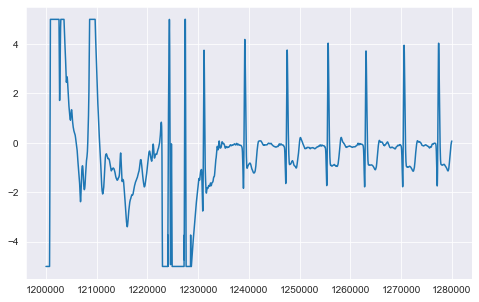

In [68]:
plt.plot(ecg)

## preprocessing

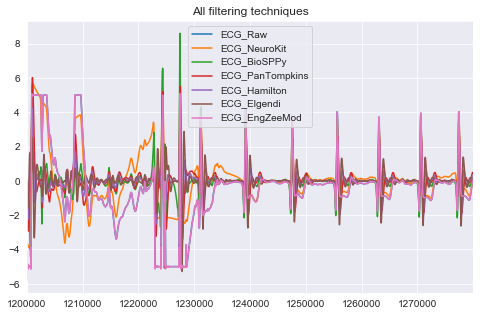

In [69]:
signals = pd.DataFrame({
        "ECG_Raw": ecg,
        "ECG_NeuroKit": nk.ecg_clean(ecg, sampling_rate, method="neurokit"),
        "ECG_BioSPPy":nk.ecg_clean(ecg, sampling_rate, method="biosppy"),
        "ECG_PanTompkins":nk.ecg_clean(ecg, sampling_rate, method="pantompkins1985"),
        "ECG_Hamilton":nk.ecg_clean(ecg, sampling_rate, method="hamilton2002"),
        "ECG_Elgendi":nk.ecg_clean(ecg, sampling_rate, method="elgendi2010"),

    "ECG_EngZeeMod":nk.ecg_clean(ecg, sampling_rate=1000, method="engzeemod2012")})
signals.plot(title='All filtering techniques')

# Pan & Tompkins, 1985
Their algorithm is a classic in the ECG processing world. I guess we could say a first standard

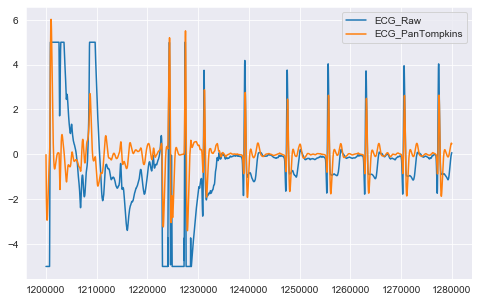

In [76]:
plt.plot(signals[['ECG_Raw', 'ECG_PanTompkins']])
plt.legend(labels = ['ECG_Raw', 'ECG_PanTompkins'])

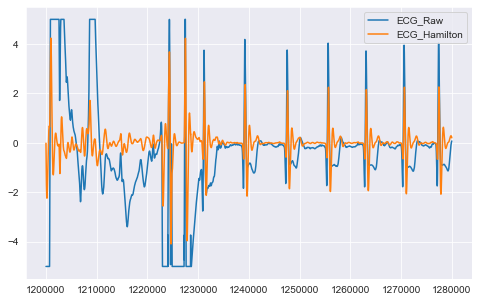

In [77]:
plt.plot(signals[['ECG_Raw', 'ECG_Hamilton']])
plt.legend(labels = ['ECG_Raw', 'ECG_Hamilton'])

# Elgendi
[Elgendi, Mohamed & Jonkman, Mirjam & De Boer, Friso. (2010)](https://researchers.cdu.edu.au/en/publications/frequency-bands-effects-on-qrs-detection). Frequency Bands Effects on QRS Detection. The 3rd International Conference on Bio-inspired Systems and Signal Processing (BIOSIGNALS2010). 428-431.

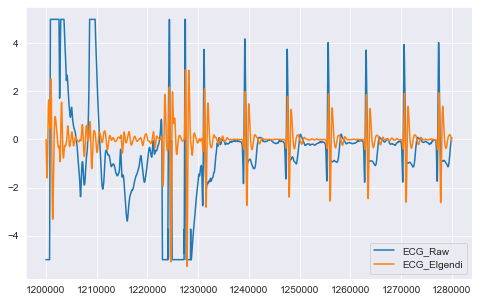

In [78]:
plt.plot(signals[['ECG_Raw', 'ECG_Elgendi']])
plt.legend(labels = ['ECG_Raw', 'ECG_Elgendi'])

Parameters :
- Butterworth
- Bandass
- Cutoffs [8 - 20]Hz

# Zeelenberg
1. [C. Zeelenberg](https://www.google.com/search?q=C.+Zeelenberg%2C+A+single+scan+algorithm+for+QRS+detection+and+feature+extraction%2C+IEEE+Comp.+in+Cardiology%2C+vol.+6%2C+pp.+37-42%2C+1979&oq=C.+Zeelenberg%2C+A+single+scan+algorithm+for+QRS+detection+and+feature+extraction%2C+IEEE+Comp.+in+Cardiology%2C+vol.+6%2C+pp.+37-42%2C+1979&aqs=chrome..69i57.10418j0j1&sourceid=chrome&ie=UTF-8), A single scan algorithm for QRS detection and feature extraction, IEEE Comp. in Cardiology, vol. 6, pp. 37-42, 1979
2. [A. Lourenco, H. Silva, P. Leite, R. Lourenco and A. Fred](http://www.lx.it.pt/~afred/papers/Real%20Time%20Electrocardiogram%20Segmentation%20for%20Finger%20Based%20ECG%20Biometrics.pdf), "Real Time Electrocardiogram Segmentation for Finger Based ECG Biometrics", BIOSIGNALS 2012, pp. 49-54, 2012.

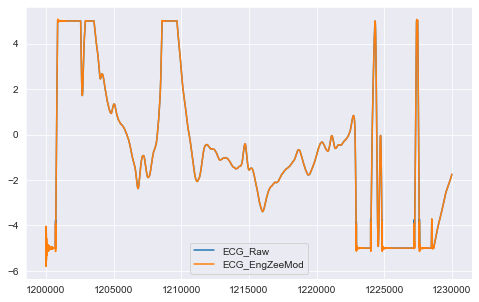

In [79]:
plt.plot(signals[['ECG_Raw', 'ECG_EngZeeMod']][:30000])
plt.legend(labels = ['ECG_Raw', 'ECG_EngZeeMod'])


# BioSPPy
adapted from [their code](https://github.com/PIA-Group/BioSPPy/blob/e65da30f6379852ecb98f8e2e0c9b4b5175416c3/biosppy/signals/ecg.py#L69).

remarks:

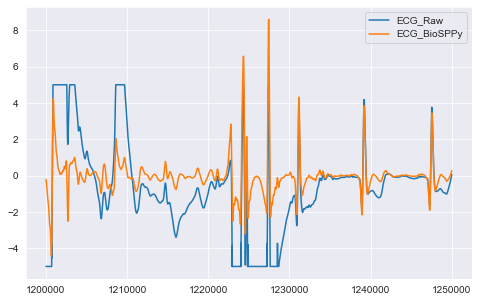

In [80]:
plt.plot(signals[['ECG_Raw', 'ECG_BioSPPy']][:50000])
plt.legend(labels = ['ECG_Raw', 'ECG_BioSPPy'])

In [103]:
def _ecg_findpeaks_kathirvel(signal, sampling_rate=1000, window_size=5.0, lfreq = 5, hfreq=15):
    """
    From : rpeakdetect: https://github.com/tru-hy/rpeakdetect/

    Kathirvel, M. Sabarimalai Manikandan et al. (2011) - An Efficient R-peak Detection Based on New Nonlinear Transformation and First-Order Gaussian Differentiator, Cardiovascular Engineering and Technology, 2, 4, 12 

   
    Returns
    ----------
    rpeaks : ndarray
        R peaks location.


    *Authors*

    - `Jami Pekkanen <https://github.com/jampekka>`_
    - `Dominique Makowski <https://dominiquemakowski.github.io/>`_
    - `François Lespinasse <https://github.com/sangfrois>`_
    """

    window_size = int(window_size*sampling_rate)
    
    # Square (=signal power) of the first difference of the signal
    decg = np.diff(signal)
    decg_power = decg**2

    # Robust threshold and normalizator estimation
    thresholds = []
    max_powers = []
    for i in range(int(len(decg_power)/window_size)):
        sample = slice(i*window_size, (i+1)*window_size)
        d = decg_power[sample]
        thresholds.append(0.5*np.std(d))
        max_powers.append(np.max(d))

    threshold = 0.5*np.std(decg_power)
    threshold = np.median(thresholds)
    max_power = np.median(max_powers)
    decg_power[decg_power < threshold] = 0

    decg_power = decg_power/max_power
    decg_power[decg_power > 1.0] = 1.0
    square_decg_power = decg_power**2

#    shannon_energy = -square_decg_power*np.log(square_decg_power)  # This errors
#    shannon_energy[np.where(np.isfinite(shannon_energy) == False)] = 0.0
    shannon_energy = -square_decg_power*np.log(square_decg_power.clip(min=1e-6))
    shannon_energy[np.where(shannon_energy <= 0)] = 0.0


    mean_window_len = int(sampling_rate*0.125+1)
    lp_energy = np.convolve(shannon_energy, [1.0/mean_window_len]*mean_window_len, mode='same')
    #lp_energy = scipy.signal.filtfilt(*lowpass2, x=shannon_energy)

    lp_energy = scipy.ndimage.gaussian_filter1d(lp_energy, sampling_rate/8.0)
    lp_energy_diff = np.diff(lp_energy)

    rpeaks = (lp_energy_diff[:-1] > 0) & (lp_energy_diff[1:] < 0)
    rpeaks = np.flatnonzero(rpeaks)

    return(rpeaks)


In [104]:
pekkanen = _ecg_findpeaks_kathirvel(signals['ECG_BioSPPy'], sampling_rate=sampling_rate)

In [105]:
pekkanen

array([ 8508, 24535, 30646, 39106, 47451, 55533, 62973, 70489, 77300],
      dtype=int64)

In [121]:
elgendi, info = nk.ecg_process(signals['ECG_Elgendi'], sampling_rate=sampling_rate, method='elgendi')